### Phase1: Collecting Required Packages and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [2]:
df = pd.read_csv("C:/Users/Mohan/Documents/___.__/Project/NZDUSD.csv")

### Phase2: Preprocessing

In [3]:
df.head()

,Date,Close
0,01/01/2002 23:58:00,0.4155
1,02/01/2002 23:58:00,0.4228
2,03/01/2002 23:58:00,0.4253
3,04/01/2002 23:58:00,0.4302
4,05/01/2002 23:58:00,0.4288


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7963 entries, 0 to 7962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7963 non-null   object 
 1   Close   7963 non-null   float64
dtypes: float64(1), object(1)
memory usage: 124.6+ KB
None


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_axis(df['Date'], inplace=True)

C:\Users\Mohan\AppData\Local\Temp\ipykernel_5480\303604782.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(df['Date'], inplace=True)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7963 entries, 2002-01-01 23:58:00 to 2023-12-31 23:58:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7963 non-null   datetime64[ns]
 1   Close   7963 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 186.6 KB


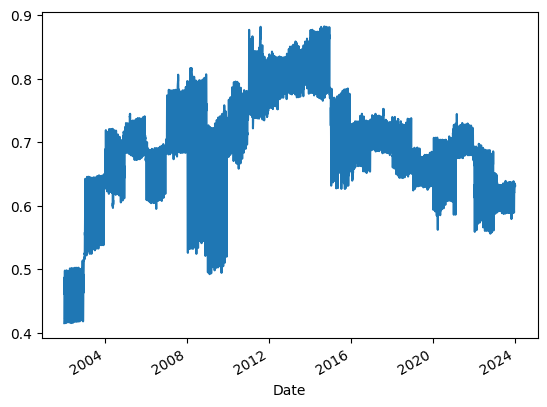

In [7]:
data=df[['Close']]
df['Close'].plot(y='Close')
plt.show()

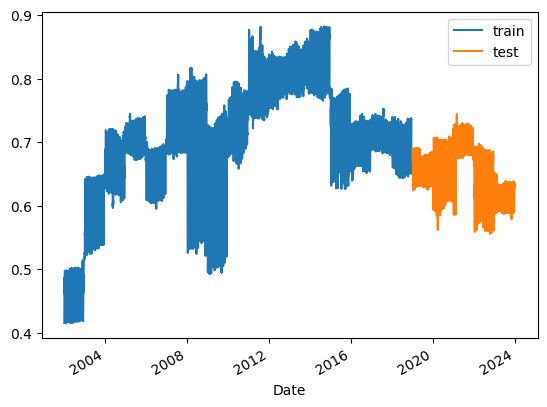

In [8]:
split_date = pd.Timestamp('2019-01-01 23:58:00')

test = data.loc[split_date:]
train = data.loc[:split_date]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)
#train_sc=np.log(train)
#test_sc=np.log(test)

In [10]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

### Phase3: Svr layer

In [11]:
model = SVR()

In [12]:
model.fit(X_train, y_train)

c:\Users\Mohan\anaconda3\envs\base_2\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [13]:
svr_predictions = model.predict(X_test)

In [14]:
svr_predictions.shape

(1825,)

In [15]:
residuals = X_test.ravel() - svr_predictions.ravel()

In [16]:
residuals.ravel()

array([0.0348649 , 0.03065356, 0.03355573, ..., 0.01283532, 0.01213095,
       0.01213095])

In [17]:
residuals= pd.DataFrame(residuals, columns=['Y'])
for s in range(1,2):
    residuals['X_{}'.format(s)] = residuals['Y'].shift(s)
    
residuals_x = residuals.dropna().drop('Y', axis=1)
residuals_y = residuals.dropna().drop('X_1', axis=1)

In [18]:
residuals_x.shape,residuals_y.shape

((1824, 1), (1824, 1))

### Phase4: RF layer

In [19]:
rf_model = RandomForestRegressor(random_state=42,max_depth=10,max_features='sqrt',min_samples_leaf = 1,min_samples_split = 5,n_estimators=100)

In [20]:
rf_model.fit(residuals_x, residuals_y)

c:\Users\Mohan\anaconda3\envs\base_2\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=5,
                      random_state=42)

In [21]:
rf_predictions = rf_model.predict(residuals_x)

In [22]:
rf_predictions=rf_predictions.reshape(-1,1)
svr_predictions=svr_predictions.reshape(-1,1)

In [23]:
rf_predictions.shape,svr_predictions.shape

((1824, 1), (1825, 1))

In [24]:
final_predictions = rf_predictions + svr_predictions[1:]

In [25]:
test_sc[1:].shape,final_predictions.shape

((1825, 1), (1824, 1))

In [26]:
test_mse = mean_squared_error(X_test[1:], final_predictions)
print('Test MSE:', test_mse)

Test MSE: 6.723671692316497e-06


In [27]:
test_sc.shape,final_predictions.shape

((1826, 1), (1824, 1))

In [28]:
mae_rf = mean_absolute_error(rf_predictions,y_test[1:])
mae_svr =mean_absolute_error(svr_predictions, y_test)
mae_hybrid =mean_absolute_error(final_predictions,y_test[1:])

mse_rf = mean_squared_error(rf_predictions,y_test[1:])
mse_svr =mean_squared_error(svr_predictions, y_test)
mse_hybrid =mean_squared_error(final_predictions,y_test[1:])

rmse_rf = np.sqrt(mean_squared_error(rf_predictions,y_test[1:]))
rmse_svr =np.sqrt(mean_squared_error(svr_predictions, y_test))
rmse_hybrid =np.sqrt(mean_squared_error(final_predictions,y_test[1:]))

r2_rf = r2_score(rf_predictions,y_test[1:])
r2_svr =r2_score(svr_predictions, y_test)
r2_hybrid =r2_score(final_predictions,y_test[1:])

### phase5:Results and Conclusions

Mean Absolute Error (SVR)    : 0.02784398700900827
Mean Absolute Error (RF)  : 0.4874032322994755
Mean Absolute Error (Hybrid): 0.006253596823307418

Mean Squared Error (SVR)    : 0.0011271304437964695
Mean Squared Error (RF)  : 0.24150142364131608
Mean Squared Error (Hybrid): 0.00015467256059631976

Root Mean Squared Error (SVR)    : 0.03357276342210259
Root Mean Squared Error (RF)  : 0.49142794348847935
Root Mean Squared Error (Hybrid): 0.012436742362705748

r2_score (SVR)    : 0.7077909308871515
r2_score (RF)  : -447.8509205395504
r2_score (Hybrid): 0.9785149691646031


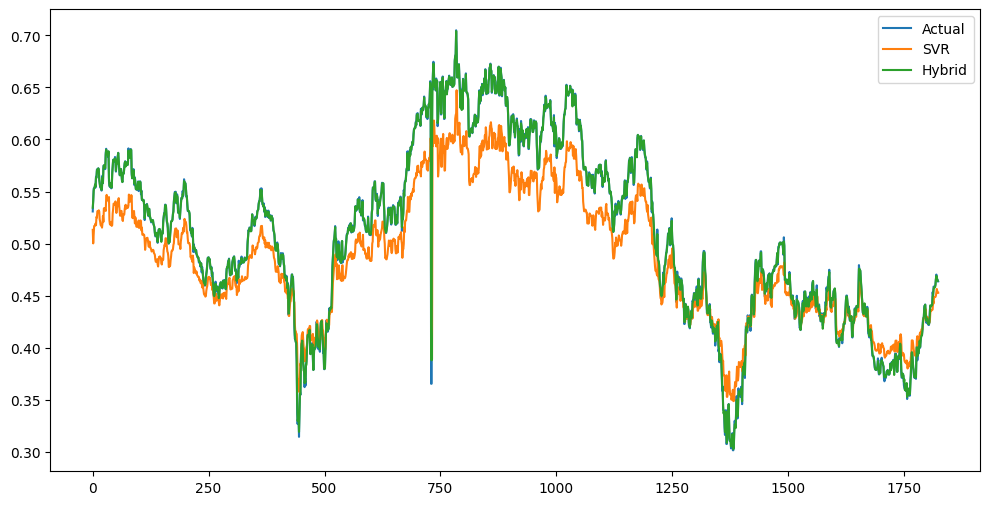

In [29]:
print("Mean Absolute Error (SVR)    :", mae_svr)
print("Mean Absolute Error (RF)  :", mae_rf)
print("Mean Absolute Error (Hybrid):", mae_hybrid)
print("")
print("Mean Squared Error (SVR)    :", mse_svr)
print("Mean Squared Error (RF)  :", mse_rf)
print("Mean Squared Error (Hybrid):", mse_hybrid)
print("")
print("Root Mean Squared Error (SVR)    :", rmse_svr)
print("Root Mean Squared Error (RF)  :", rmse_rf)
print("Root Mean Squared Error (Hybrid):", rmse_hybrid)
print("")
print("r2_score (SVR)    :", r2_svr)
print("r2_score (RF)  :", r2_rf)
print("r2_score (Hybrid):", r2_hybrid)

# Plot forecasts
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(svr_predictions, label='SVR')
#plt.plot(svr_predictions, label='ARIMA')
plt.plot(final_predictions, label='Hybrid')
plt.legend()
plt.show()

In [30]:
final_predictions=np.array(final_predictions)
final_predictions=pd.DataFrame(final_predictions)
final_predictions.to_csv('SVR_RF_NZDINR.csv', index=False)